#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [1]:
import torch as th
import torch.nn as nn

In [2]:
imgs = th.rand(16, 3, 100, 100)
# bounding box
bboxes = th.rand(16, 4)
labels = th.randint(0, 2, size=(16, ))

In [3]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.backbone = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=2),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    in_features = 153664  # 64*49*49
    self.regressor = nn.Sequential(
        nn.Linear(in_features, 64),
        nn.ReLU(),
        nn.Linear(64, 4)
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
    )

  def forward(self, X):
    features = self.backbone(X) # b x c x h x w
    features = features.flatten(start_dim=1)

    return self.regressor(features), self.classifier(features)

In [4]:
model = Model()
bboxes_pred, labels_pred = model(imgs)

In [5]:
bboxes_pred.shape

torch.Size([16, 4])

In [6]:
labels_pred.shape

torch.Size([16, 2])

In [7]:
import torch.nn.functional as F

loss_reg = F.mse_loss(bboxes_pred, bboxes)
loss_class = F.cross_entropy(labels_pred, labels)

In [8]:
loss_reg, loss_class

(tensor(0.3696, grad_fn=<MseLossBackward0>),
 tensor(0.6965, grad_fn=<NllLossBackward0>))

In [9]:
loss = loss_reg + loss_class

## Задачи для самостоятельного решения

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import shutil

archive_path = '/content/drive/My Drive/animals.zip'
extract_path = 'animals.zip'
shutil.copy(archive_path, extract_path)


'animals.zip'

In [ ]:
!unzip animals.zip

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [5]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    raw_coords = {}
    scaled_coords = {}
    obj_name = ""

    for obj in root.findall('object'):
        obj_name = obj.find('name').text
        bndbox = obj.find('bndbox')
        raw_coords = {
            "xmin": float(bndbox.find('xmin').text),
            "ymin": float(bndbox.find('ymin').text),
            "xmax": float(bndbox.find('xmax').text),
            "ymax": float(bndbox.find('ymax').text)
        }
        width = float(root.find('size').find('width').text)
        height = float(root.find('size').find('height').text)
        scaled_coords = {
            "xmin": raw_coords["xmin"] / width,
            "ymin": raw_coords["ymin"] / height,
            "xmax": raw_coords["xmax"] / width,
            "ymax": raw_coords["ymax"] / height
        }

    return {
        "raw": raw_coords,
        "scaled": scaled_coords,
        "obj_name": obj_name
    }


In [6]:
result = parse_xml('/content/Asirra: cat vs dogs/cat.0.xml')
print(result)

{'raw': {'xmin': 126.0, 'ymin': 83.0, 'xmax': 354.0, 'ymax': 243.0}, 'scaled': {'xmin': 0.252, 'ymin': 0.22192513368983957, 'xmax': 0.708, 'ymax': 0.6497326203208557}, 'obj_name': 'cat'}


<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [7]:
from torch.utils.data import Dataset

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform = None, return_scaled=True):
        pass

In [8]:
class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform=None, return_scaled=True):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled

        self.unique_filenames = np.unique([os.path.splitext(filename)[0] for filename in os.listdir(self.root) if filename.endswith('.xml')])

    def __getitem__(self, idx):

        unique_filename = self.unique_filenames[idx]


        image_path = os.path.join(self.root, unique_filename + '.jpg')
        xml_path = os.path.join(self.root, unique_filename + '.xml')


        parsed_data = parse_xml(xml_path)
        object_name = parsed_data['obj_name']


        if self.return_scaled:
            bounding_box = {
                'xmin': parsed_data['scaled']['xmin'],
                'ymin': parsed_data['scaled']['ymin'],
                'xmax': parsed_data['scaled']['xmax'],
                'ymax': parsed_data['scaled']['ymax']
            }
        else:
            bounding_box = {
                'xmin': parsed_data['raw']['xmin'],
                'ymin': parsed_data['raw']['ymin'],
                'xmax': parsed_data['raw']['xmax'],
                'ymax': parsed_data['raw']['ymax']
            }


        if self.target_transform:
            object_name = self.target_transform[object_name]


        image = Image.open(image_path).convert('RGB')


        if self.transforms:
            image = self.transforms(image)
        else:
            image = torch.tensor(np.array(image))

        return image, bounding_box, object_name

    def __len__(self):
        return len(self.unique_filenames)


<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [10]:
dataset = AnimalDetectionDataset(root='/content/Asirra: cat vs dogs/', transforms=None, target_transform=None, return_scaled=False)


In [11]:
dataset[0]

(tensor([[[203, 164,  87],
          [203, 164,  87],
          [204, 165,  88],
          ...,
          [240, 201, 122],
          [239, 200, 121],
          [238, 199, 120]],
 
         [[203, 164,  87],
          [203, 164,  87],
          [204, 165,  88],
          ...,
          [241, 202, 123],
          [240, 201, 122],
          [238, 199, 120]],
 
         [[203, 164,  87],
          [203, 164,  87],
          [204, 165,  88],
          ...,
          [241, 202, 123],
          [240, 201, 122],
          [239, 200, 121]],
 
         ...,
 
         [[153, 122,  55],
          [153, 122,  55],
          [153, 122,  55],
          ...,
          [  2,   2,   0],
          [  2,   2,   0],
          [  2,   2,   0]],
 
         [[152, 121,  54],
          [152, 121,  54],
          [152, 121,  54],
          ...,
          [  2,   2,   0],
          [  2,   2,   0],
          [  2,   2,   0]],
 
         [[151, 120,  53],
          [151, 120,  53],
          [151, 120,  53],
   

In [12]:
def show_image_with_bounding_box(dataset, k):
    image, bounding_box, object_name = dataset[k]
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    xmin = bounding_box['xmin']
    ymin = bounding_box['ymin']
    xmax = bounding_box['xmax']
    ymax = bounding_box['ymax']

    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.text(xmin, ymin - 5, object_name, color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

    plt.show()


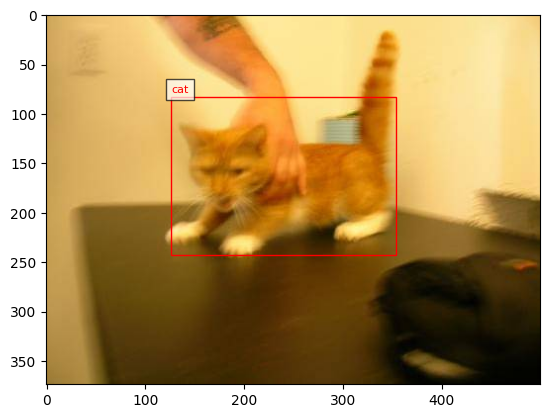

In [13]:
show_image_with_bounding_box(dataset, 0)

In [14]:
len(dataset)

1100

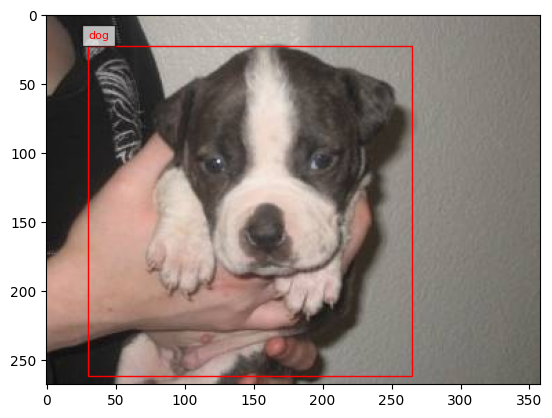

In [15]:
show_image_with_bounding_box(dataset, 998)

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

In [58]:
class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ObjectDetectionModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)

        self.regressor = nn.Sequential(
            nn.Linear(self.backbone.fc.out_features, 4))

        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.fc.out_features, num_classes)
        )

        self.backbone.fc = nn.Identity()

    def forward(self, x):
        features = self.backbone(x)
        bboxes = self.regressor(features)
        logits = self.classifier(features)

        return bboxes, logits


<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [18]:
models.ResNet50_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [34]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = {'cat': 0, 'dog': 1}

In [35]:
dataset = AnimalDetectionDataset('/content/Asirra: cat vs dogs/', transform, target_transform, True)
len(dataset)

1100

In [21]:
import torch
from torch.utils.data import random_split
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import MSELoss, CrossEntropyLoss

In [59]:

train, test = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32)

model = ObjectDetectionModel(num_classes=2)

for param in model.backbone.parameters():
    param.requires_grad = False

In [60]:
regression_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [62]:
epochs = 10

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

<p class="task" id="7"></p>

7*\. Повторите решение предыдущей задачи, используя модель `fasterrcnn_resnet50_fpn`. Замените слой для предсказания bounding box на `FastRCNNPredictor` с нужным количеством классов.

- [ ] Проверено на семинаре

## Обратная связь
- [ ] Хочу получить обратную связь по решению